# Matching Initials: A Surprising Pattern in Spouse Preference

## Imports

In [1]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import numpy as np
from tqdm import tqdm

plt.style.use('ggplot')

## Data

In [2]:
with open("data/marriage_data.pkl", "rb") as f:
    data = pkl.load(f)

year_min = data['LICENSE_YEAR'].min()
year_max = data['LICENSE_YEAR'].max()
print(f'Time period: {year_min}-{year_max}')
print(f"Number of marriages: {len(data)}")

# we care only about the first letter of the names
gi = data['GROOM_FIRST_NAME'].str[0]
bi = data['BRIDE_FIRST_NAME'].str[0]

N = len(data)

Time period: 1950-2017
Number of marriages: 3635116


### Number of marriages per year

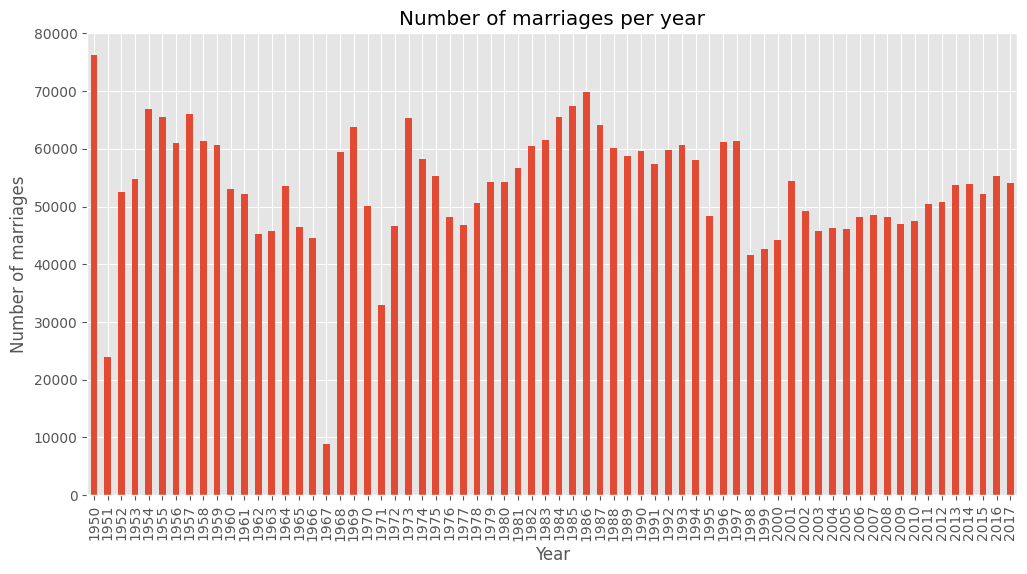

In [3]:
N_per_year = data.groupby('LICENSE_YEAR').size()
N_per_year.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of marriages')
plt.title('Number of marriages per year')
plt.show()

There are some fluctuations, some of which may be due to inaccurate reporting (e.g. 1951 and 1971), but overall there is nothing too surprising except the abnormally low number of records for 1967. The missing data for 1967 is mentioned in the data documentation online and does not impact our study.

### Most popular names

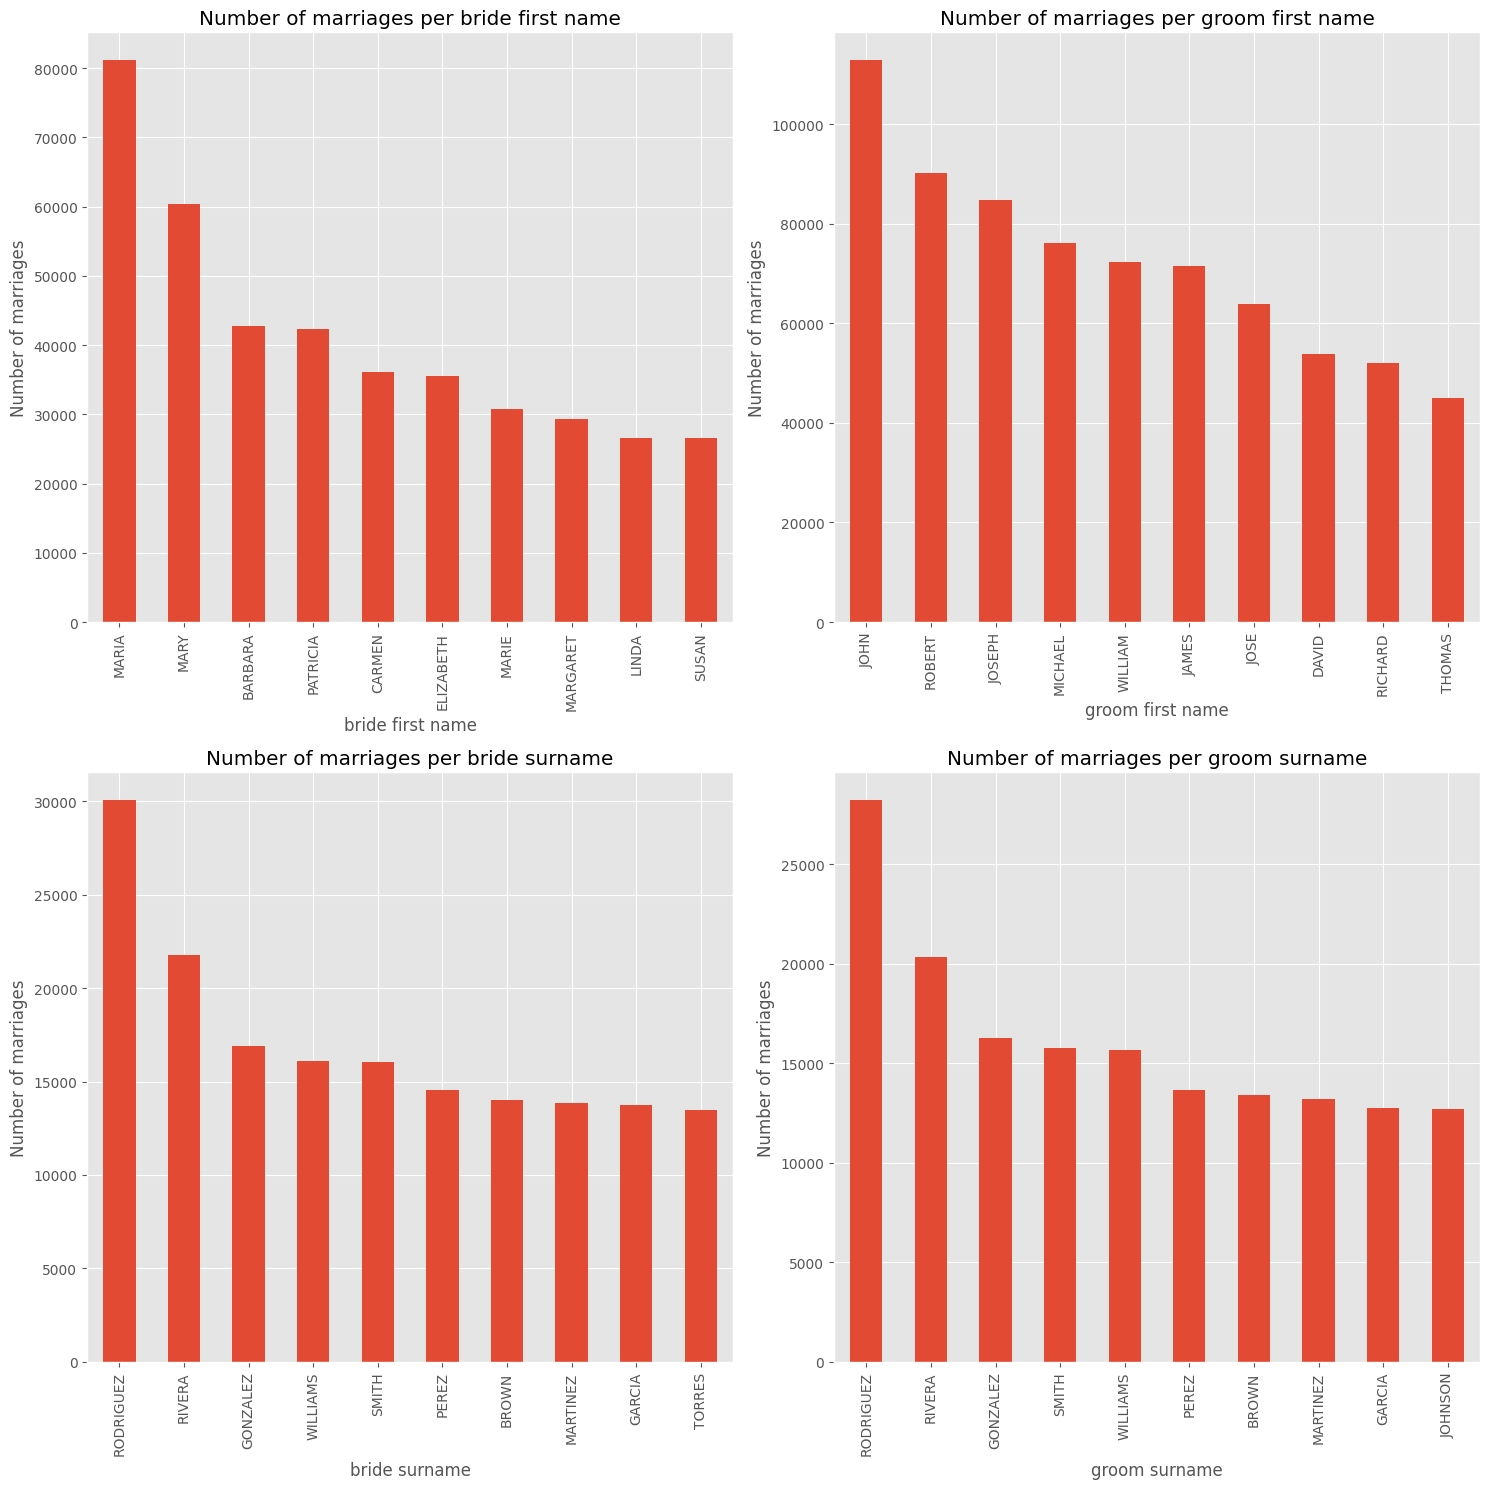

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
for i, name in enumerate(['BRIDE_FIRST_NAME', 'GROOM_FIRST_NAME', 'BRIDE_SURNAME', 'GROOM_SURNAME']):
    ax = axs[i // 2, i % 2]
    data[name].value_counts().head(10).plot(kind='bar', ax=ax)
    ax.set_ylabel('Number of marriages')
    ax.set_xlabel(name.lower().replace("_", " "))
    ax.set_title(f'Number of marriages per {name.lower().replace("_", " ")}')
plt.tight_layout()
plt.show()

No surprises here, we find the common English catholic first names alongside their Italian/Portuguese/Spanish equivalents. The last names are the stereotypical American last names (proof that stereotypes can sometimes be true!), alongside popular Italian/Portuguese/Spanish last names which account for the large European diaspora in NYC.

### Distribution of first name initials

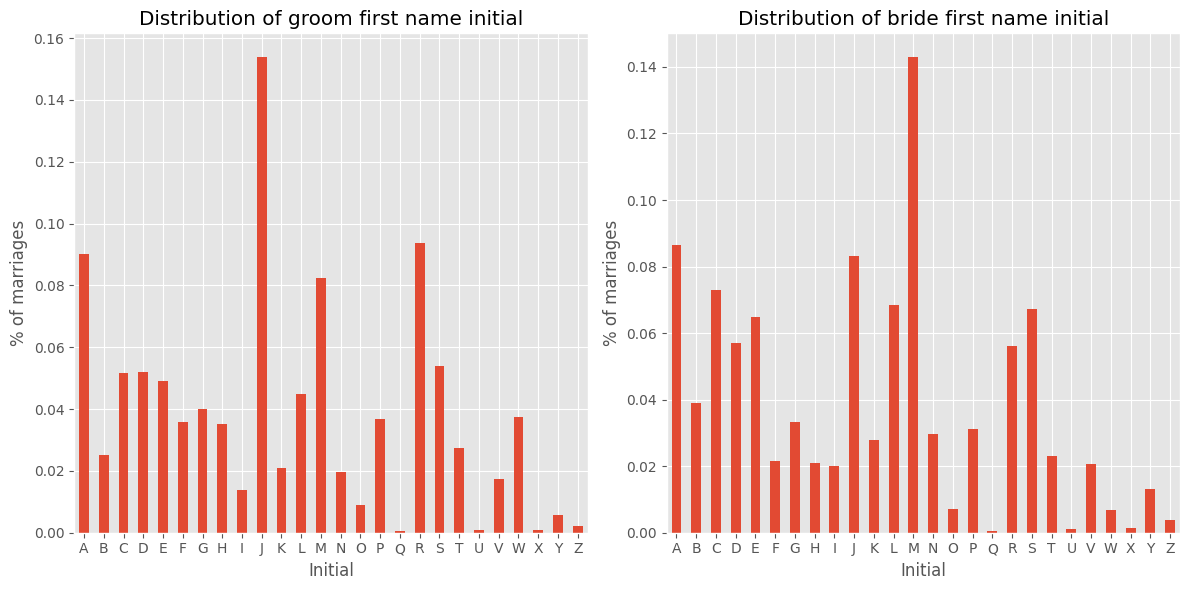

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

gi.value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(12, 6), ax=axs[0])
axs[0].set_xlabel('Initial')
axs[0].set_ylabel('% of marriages')
axs[0].set_title('Distribution of groom first name initial')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0)

bi.value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(12, 6), ax=axs[1])
axs[1].set_xlabel('Initial')
axs[1].set_ylabel('% of marriages')
axs[1].set_title('Distribution of bride first name initial')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

Nothing too surprising here either, J for JOHN and M for MARY/MARIE/MARIA dominate significantly. Initials Q, W, X, Y, Z are rare and account mainly for the Chinese population in NYC. Perhaps expectedly, U is almost non-existent for both genders.

## I. Matching initials

Let's now focus more closely on matching initials. Do we have more people marrying someone with the same initial than expected?

One simple way to answer this query is to look at each couple $(g,b)$ of groom initial and bride initial and compare the observed frequency (in the data) $f_{gb}$ to the expected frequency $f_g f_b$. (note for now that $f_g$ and $f_b$ are themselves estimated from the data but given the very large size of our dataset we expect them to be very close to their true values)

If our hypothesis that people like marrying partners with the same initial is correct, we should have $f_{\alpha \alpha} > f_\alpha f_\alpha$ for most letters $\alpha$. In other words, we should observe a higher frequency of matching-initials marriages than expected. Let's see if that's the case.

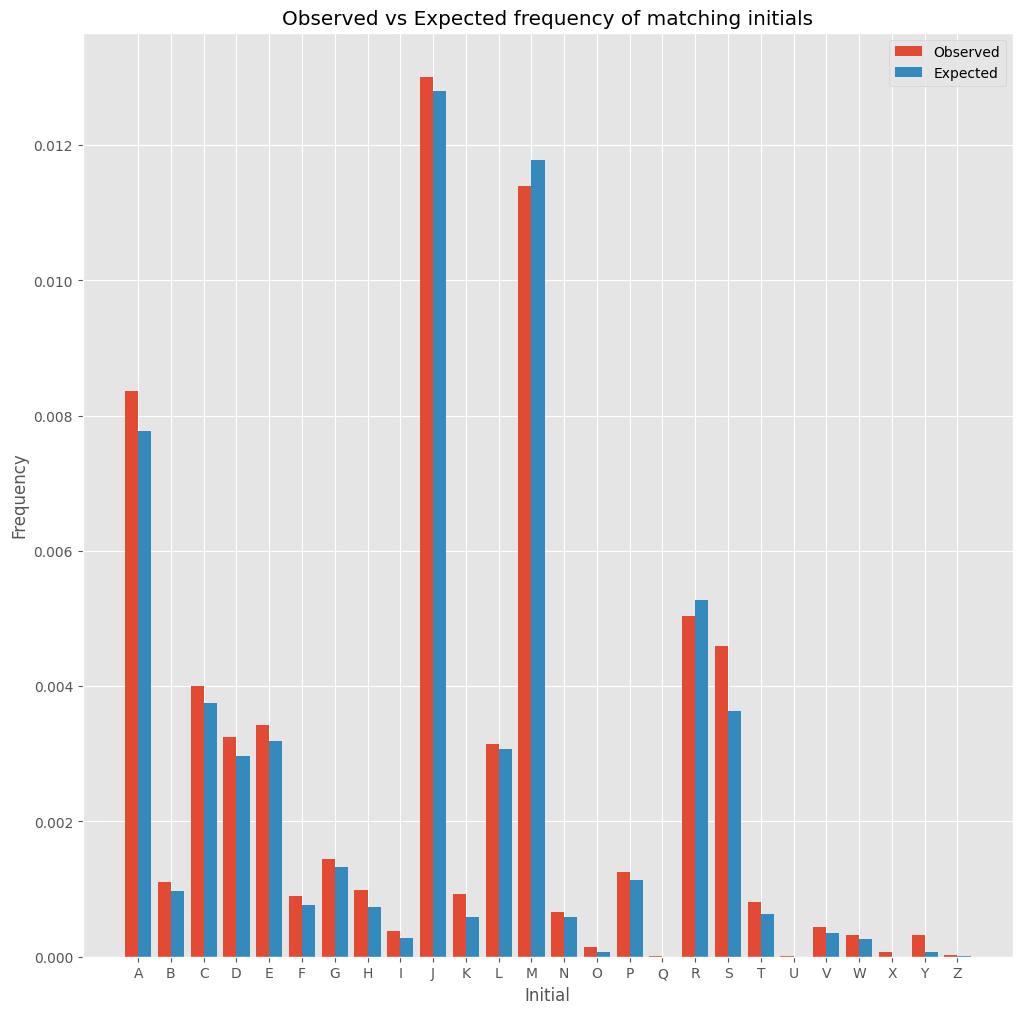

In [6]:
ALPHABET = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

obs_freq = pd.crosstab(gi,bi,normalize=True)
pg = gi.value_counts(normalize=True).sort_index()
pb = bi.value_counts(normalize=True).sort_index()
exp_freq = pd.DataFrame(np.outer(pg, pb), index=pg.index, columns=pb.index).astype(float)

# keeping the diagonal only since we are interested in matching initials
obs_freq = np.diag(obs_freq)
exp_freq = np.diag(exp_freq)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# plot the observed vs expected frequencies in the same barplot, with the bars adjacent
width = 0.4
x = np.arange(len(ALPHABET))
ax.bar(x - width/2, obs_freq, width, label='Observed')
ax.bar(x + width/2, exp_freq, width, label='Expected')
ax.set_xticks(x)
ax.set_xticklabels(ALPHABET)
ax.set_xlabel('Initial')
ax.set_ylabel('Frequency')
ax.set_title('Observed vs Expected frequency of matching initials')
ax.legend()
plt.show()

Let's look at the absolute difference $\Delta=observed-expected$ and the relative difference $\Delta_{rel.}=\frac{observed-expected}{expected}$ to see better.

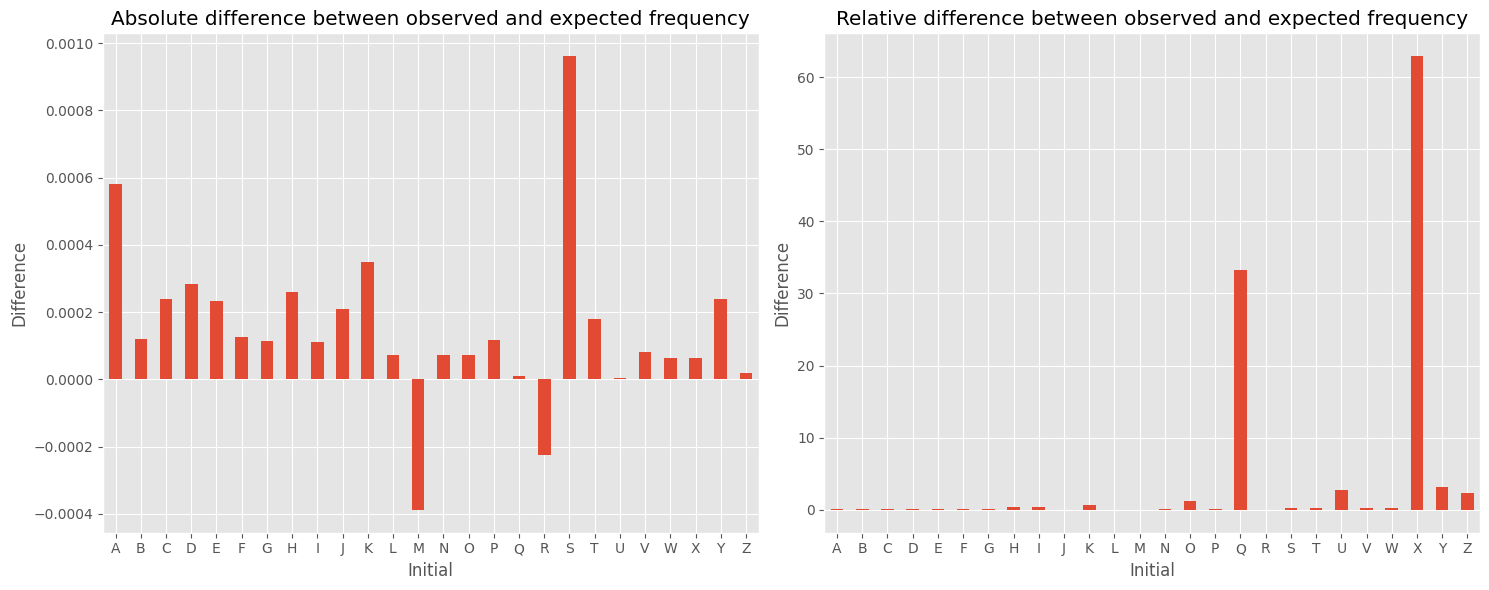

In [7]:
abs_diff = obs_freq - exp_freq
rel_diff = (obs_freq - exp_freq) / exp_freq

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
pd.Series(abs_diff, index=ALPHABET).plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('Initial')
axs[0].set_ylabel('Difference')
axs[0].set_title('Absolute difference between observed and expected frequency')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0)

pd.Series(rel_diff, index=ALPHABET).plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('Initial')
axs[1].set_ylabel('Difference')
axs[1].set_title('Relative difference between observed and expected frequency')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [8]:
ALPHABET = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
res = pd.DataFrame(index=ALPHABET,columns=[r'p_{\alpha\alpha}',r'p^G_\alpha p^B_\alpha', r'z_\alpha','p-value'])

for alpha in ALPHABET:
    pga = (gi==alpha).mean()
    pba = (bi==alpha).mean()
    paa = ((gi==alpha) & (bi==alpha)).mean()
    vec_u = np.array([-pba,-pga,1])
    mat_sigma = np.array([[pga*(1-pga),paa-pga*pba,paa*(1-pga)],[paa-pga*pba,pba*(1-pba),paa*(1-pba)],[paa*(1-pga),paa*(1-pba),paa*(1-paa)]]).astype(float)
    s2 = vec_u.T @ mat_sigma @ vec_u
    s2_prime = vec_u[:2].T @ mat_sigma[:2,:2] @ vec_u[:2]
    se = np.sqrt(s2 / N)
    se_prime = np.sqrt(s2_prime / N)
    z_alpha = (paa - pga*pba) / se
    z_alpha_prime = (pga*pba) / se_prime
    p_value = 2 * (1 - sts.norm.cdf(abs(z_alpha))) # two-tailed test...
    res.loc[alpha] = [paa,pga*pba,z_alpha,p_value]

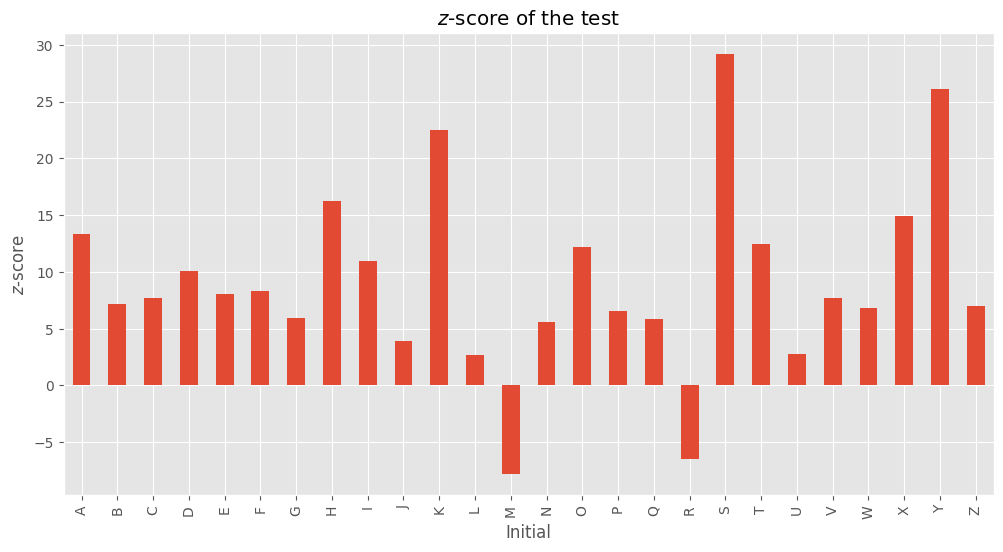

In [9]:
# plot histogram of z-scores
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
res[r'z_\alpha'].plot(kind='bar', ax=ax)
ax.set_xlabel('Initial')
ax.set_ylabel('$z$-score')
ax.set_title('$z$-score of the test')
plt.show()

## II. Control: repeating the same experiment on groom last letter and bride first letter

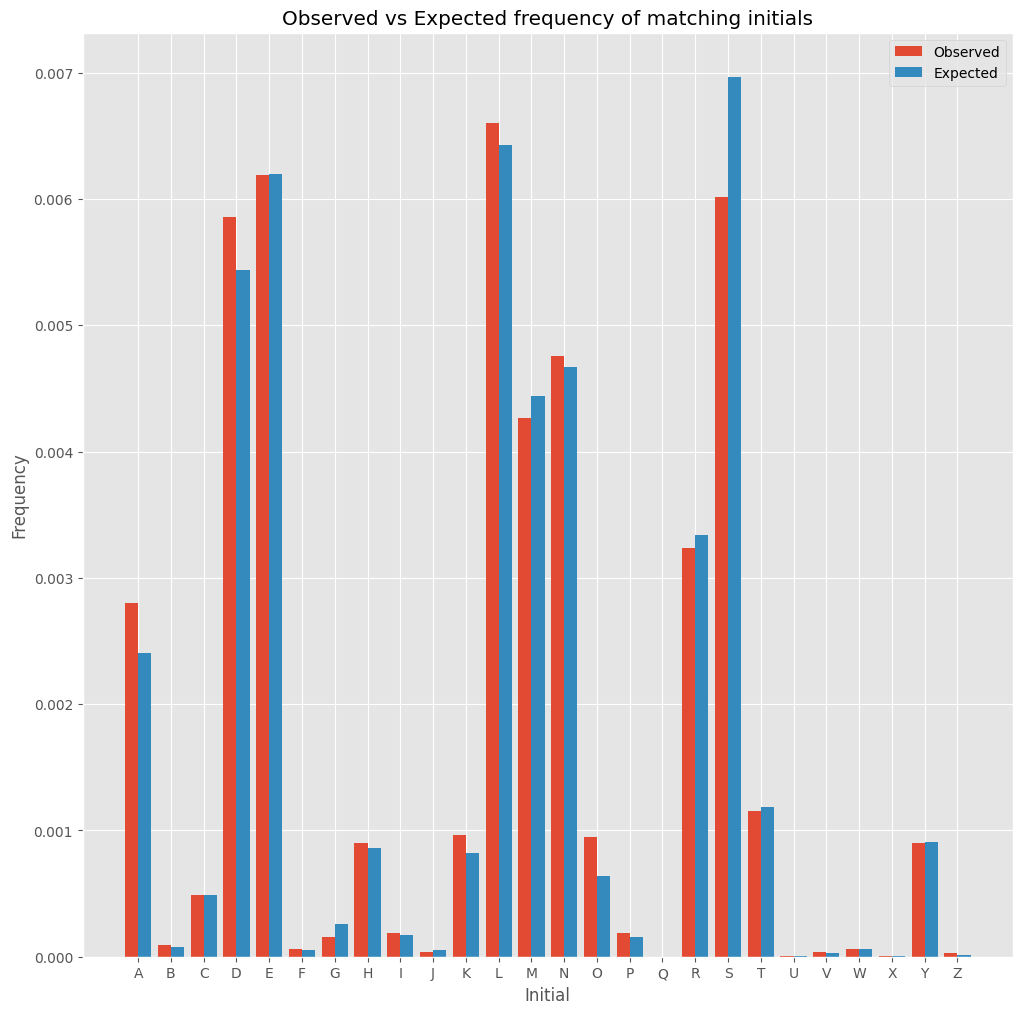

In [10]:
gl = data['GROOM_FIRST_NAME'].str[-1] # groom last letter
bl = data['BRIDE_FIRST_NAME'].str[0] # bride first letter

ALPHABET = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

obs_freq = pd.crosstab(gl,bl,normalize=True)
pg = gl.value_counts(normalize=True).sort_index()
pb = bl.value_counts(normalize=True).sort_index()
exp_freq = pd.DataFrame(np.outer(pg, pb), index=pg.index, columns=pb.index).astype(float)

# keeping the diagonal only since we are interested in matching initials
obs_freq = np.diag(obs_freq)
exp_freq = np.diag(exp_freq)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# plot the observed vs expected frequencies in the same barplot, with the bars adjacent
width = 0.4
x = np.arange(len(ALPHABET))
ax.bar(x - width/2, obs_freq, width, label='Observed')
ax.bar(x + width/2, exp_freq, width, label='Expected')
ax.set_xticks(x)
ax.set_xticklabels(ALPHABET)
ax.set_xlabel('Initial')
ax.set_ylabel('Frequency')
ax.set_title('Observed vs Expected frequency of matching initials')
ax.legend()
plt.show()

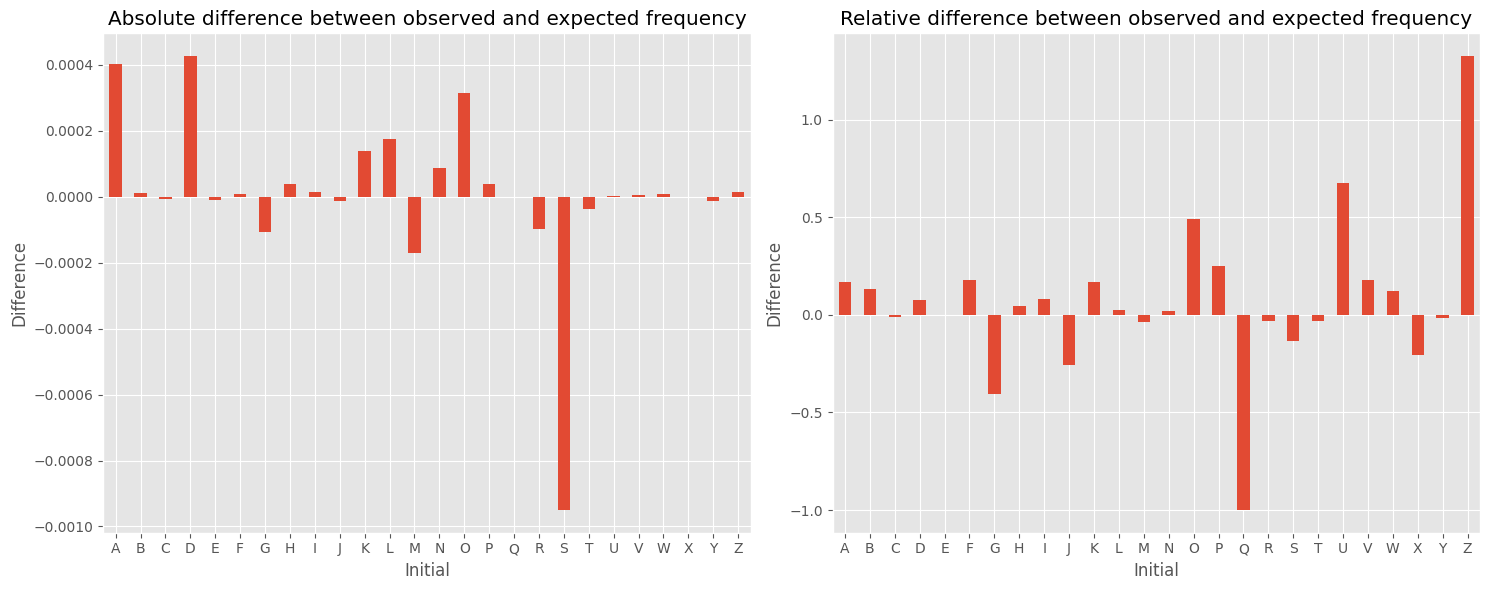

In [11]:
abs_diff = obs_freq - exp_freq
rel_diff = (obs_freq - exp_freq) / exp_freq

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
pd.Series(abs_diff, index=ALPHABET).plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('Initial')
axs[0].set_ylabel('Difference')
axs[0].set_title('Absolute difference between observed and expected frequency')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0)

pd.Series(rel_diff, index=ALPHABET).plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('Initial')
axs[1].set_ylabel('Difference')
axs[1].set_title('Relative difference between observed and expected frequency')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [12]:
ALPHABET = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
res = pd.DataFrame(index=ALPHABET,columns=[r'p_{\alpha\alpha}',r'p^G_\alpha p^B_\alpha', r'z_\alpha','p-value'])

for alpha in ALPHABET:
    pga = (gl==alpha).mean()
    pba = (bl==alpha).mean()
    paa = ((gl==alpha) & (bl==alpha)).mean()
    vec_u = np.array([-pba,-pga,1])
    mat_sigma = np.array([[pga*(1-pga),paa-pga*pba,paa*(1-pga)],[paa-pga*pba,pba*(1-pba),paa*(1-pba)],[paa*(1-pga),paa*(1-pba),paa*(1-paa)]]).astype(float)
    s2 = vec_u.T @ mat_sigma @ vec_u
    s2_prime = vec_u[:2].T @ mat_sigma[:2,:2] @ vec_u[:2]
    se = np.sqrt(s2 / N)
    se_prime = np.sqrt(s2_prime / N)
    z_alpha = (paa - pga*pba) / se
    z_alpha_prime = (pga*pba) / se_prime
    p_value = 2 * (1 - sts.norm.cdf(abs(z_alpha))) # two-tailed test...
    res.loc[alpha] = [paa,pga*pba,z_alpha,p_value]

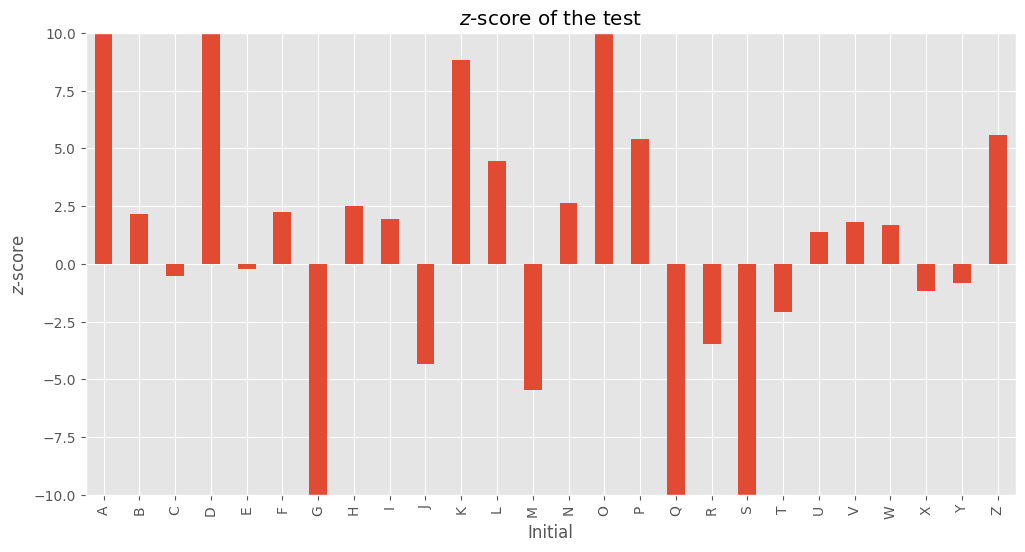

In [13]:
# plot histogram of z-scores
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
res[r'z_\alpha'].plot(kind='bar', ax=ax)
ax.set_xlabel('Initial')
ax.set_ylabel('$z$-score')
ax.set_title('$z$-score of the test')
ax.set_ylim(-10,10)
plt.show()